### Understanding the Wine Dataset

In [2]:
# wine_data.csv
from google.colab import files
uploaded = files.upload()

Saving wine_data.csv to wine_data (1).csv


In [3]:
import pandas as pd
import numpy as np
wine = pd.read_csv("wine_data.csv")


In [ ]:
# columns
print("wine.columns:\n{}".format(wine.columns.tolist()))

wine.columns:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']


In [ ]:
# shape of the dataset
print("Shape of wine data: {}".format(wine.shape))

Shape of wine data: (1359, 12)


In [ ]:
# sample counts per class (0 = bad, 1 = good)
print("Sample counts per class:\n{}".format(wine['quality'].value_counts().sort_index()))

Sample counts per class:
quality
0    638
1    721
Name: count, dtype: int64


In [ ]:
# feature names
feature_names = wine.columns[:-1]
target_names = ['bad', 'good']
print("Feature names:\n{}".format(feature_names.tolist()))

print("Target names: {}".format(target_names))

# print first 5 samples
for i in range(5):
    print(wine.iloc[i, :-1].values, wine.iloc[i, -1])

Feature names:
['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Target names: ['bad', 'good']
[ 7.7     0.56    0.08    2.5     0.114  14.     46.      0.9971  3.24
  0.66    9.6   ] 1
[7.80e+00 5.00e-01 1.70e-01 1.60e+00 8.20e-02 2.10e+01 1.02e+02 9.96e-01
 3.39e+00 4.80e-01 9.50e+00] 0
[10.7     0.67    0.22    2.7     0.107  17.     34.      1.0004  3.28
  0.98    9.9   ] 1
[ 8.5    0.46   0.31   2.25   0.078 32.    58.     0.998  3.33   0.54
  9.8  ] 0
[ 6.7     0.46    0.24    1.7     0.077  18.     34.      0.9948  3.39
  0.6    10.6   ] 1


### Accuracy Scores Overview
Approach 1: Simple Decision Tree
- Training Accuracy: 0.746
- Validation Accuracy: 0.735
- Sample Test Set Accuracy: 0.750
- Average cross-validation score: 0.684

Approach 2: Light GBM
- Training Accuracy: 0.853
- Validation Accuracy: 0.739
- Sample Test Set Accuracy: 0.870
- Average cross-validation score: 0.755

Approach 3: Stacking (GB + RF + LR)
- Training Accuracy: 0.893
- Validation Accuracy: 0.757
- Sample Test Set Accuracy: 0.900
- Average cross-validation score: 0.783

### Task 1

In [ ]:
# approach: simple decision tree
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

wine = pd.read_csv("wine_data.csv")

X = wine.drop("quality", axis=1)
y = wine["quality"]
train_feature, test_feature, train_class, test_class = train_test_split(
    X.values, y.values, stratify=y, test_size=0.2, random_state=42)

tree = DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=4,
    criterion='entropy',
    max_features='sqrt',
    random_state=0
)
tree.fit(train_feature, train_class)
print("Training Accuracy: {:.3f}".format(tree.score(train_feature, train_class)))
print("Validation Accuracy: {:.3f}".format(tree.score(test_feature, test_class)))

Training set score: 0.746
Validation set score: 0.735


In [ ]:
# confusion matrix - training
train_prediction = tree.predict(train_feature)
print("\nTraining Confusion Matrix:")
print(pd.crosstab(train_class, train_prediction, rownames=['True'], colnames=['Predicted'], margins=True))

# confusion matrix - validation
test_prediction = tree.predict(test_feature)
print("\nValidation Confusion Matrix:")
print(pd.crosstab(test_class, test_prediction, rownames=['True'], colnames=['Predicted'], margins=True))


Training Confusion Matrix:
Predicted    0    1   All
True                     
0          438   72   510
1          164  413   577
All        602  485  1087

Validation Confusion Matrix:
Predicted    0    1  All
True                    
0           96   32  128
1           52   92  144
All        148  124  272


In [6]:
# approach: light gbm & stacking
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier

wine = pd.read_csv("wine_data.csv")
wine['volatile acidity'] = wine['alcohol'] * wine['fixed acidity']
wine['acidity_ratio'] = wine['fixed acidity'] / (wine['volatile acidity'] + 1e-5)
wine['sulfur_ratio'] = wine['free sulfur dioxide'] / (wine['total sulfur dioxide'] + 1e-5)

X = wine.drop("quality", axis=1)
y = wine["quality"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

# light gbm classifier
lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=0,
    verbose=-1,
    verbosity=-1
)
lgbm.fit(X_train, y_train)
print("LightGBM - Training Accuracy: {:.3f}".format(lgbm.score(X_train, y_train)))
print("LightGBM - Validation Accuracy: {:.3f}".format(lgbm.score(X_test, y_test)))

# stacking: grdient boosting + random forest + logistic regression
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_samples_leaf=4,
    subsample=0.9,
    random_state=0
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=0
)

stacked = StackingClassifier(
    estimators=[
        ('gb', gb),
        ('rf', rf)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

stacked.fit(X_train, y_train)

print("\nStacking - Training Accuracy: {:.3f}".format(stacked.score(X_train, y_train)))
print("Stacking - Validation Accuracy: {:.3f}".format(stacked.score(X_test, y_test)))


LightGBM - Training Accuracy: 0.853
LightGBM - Validation Accuracy: 0.739

Stacking - Training Accuracy: 0.893
Stacking - Validation Accuracy: 0.757


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# light gbm confusion matrix
lgbm_train_pred = lgbm.predict(X_train)
lgbm_test_pred = lgbm.predict(X_test)

print("\nLightGBM - Training Confusion Matrix:")
print(pd.crosstab(y_train, lgbm_train_pred, rownames=['True'], colnames=['Predicted'], margins=True))

print("\nLightGBM - Validation Confusion Matrix:")
print(pd.crosstab(y_test, lgbm_test_pred, rownames=['True'], colnames=['Predicted'], margins=True))

# stacking confusion matrix
stack_train_pred = stacked.predict(X_train)
stack_test_pred = stacked.predict(X_test)

print("\nStacking - Training Confusion Matrix:")
print(pd.crosstab(y_train, stack_train_pred, rownames=['True'], colnames=['Predicted'], margins=True))

print("\nStacking - Validation Confusion Matrix:")
print(pd.crosstab(y_test, stack_test_pred, rownames=['True'], colnames=['Predicted'], margins=True))



LightGBM - Training Confusion Matrix:
Predicted    0    1   All
True                     
0          435   75   510
1           85  492   577
All        520  567  1087

LightGBM - Validation Confusion Matrix:
Predicted    0    1  All
True                    
0           94   34  128
1           37  107  144
All        131  141  272

Stacking - Training Confusion Matrix:
Predicted    0    1   All
True                     
0          451   59   510
1           57  520   577
All        508  579  1087

Stacking - Validation Confusion Matrix:
Predicted    0    1  All
True                    
0           94   34  128
1           32  112  144
All        126  146  272


#### Decision Tree Visualisation

In [ ]:
!apt-get -qq install -y graphviz

In [ ]:
 !pip install graphviz

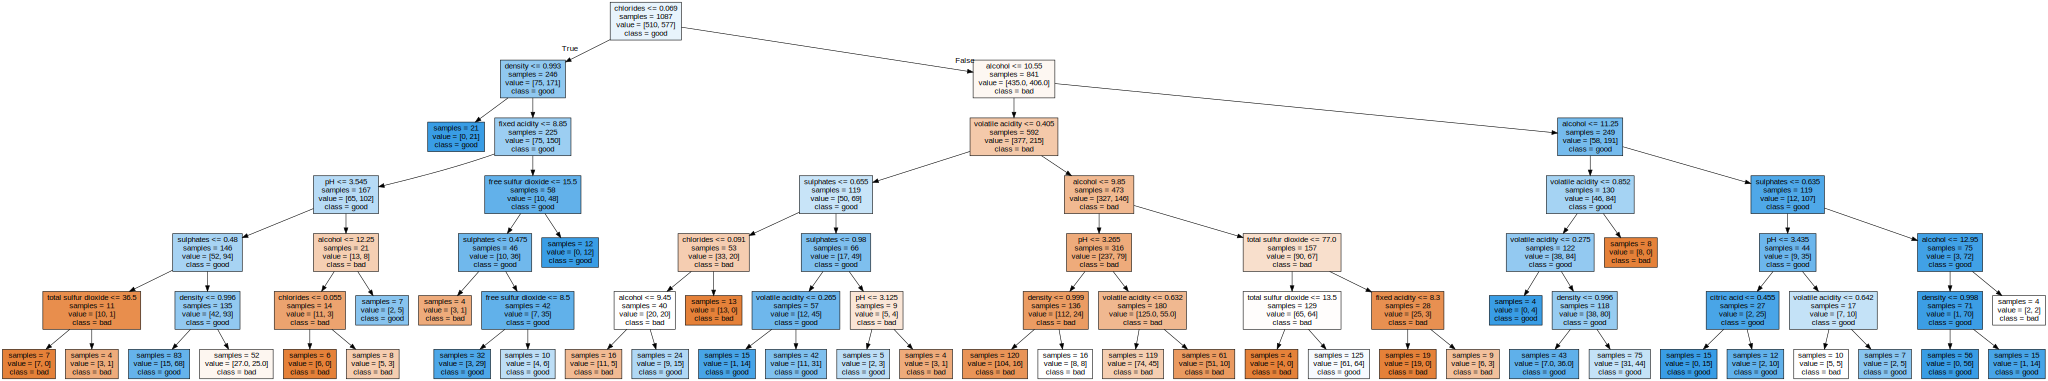

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display

export_graphviz(tree, out_file="tree.dot", class_names=["bad", "good"],
                feature_names=X.columns, impurity=False, filled=True)

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))


In [ ]:
# feature importances
print("Feature importances:\n{}".format(tree.feature_importances_))

Feature importances:
[0.03691864 0.133088   0.00727982 0.         0.11432927 0.02034576
 0.0511062  0.11610967 0.04370076 0.10678176 0.37034011]


### Task 2

In [ ]:
# wine_data_test.csv
from google.colab import files
uploaded = files.upload()

Saving wine_data_test.csv to wine_data_test.csv


In [ ]:
# approach: simple decision tree
import pandas as pd
from sklearn.metrics import accuracy_score

test_data = pd.read_csv("wine_data_test.csv")

X_dummy_test = test_data.drop("quality", axis=1)
y_dummy_test = test_data["quality"]

dummy_predictions = tree.predict(X_dummy_test)
dummy_accuracy = accuracy_score(y_dummy_test, dummy_predictions)
print("Sample Test Set Accuracy: {:.3f}".format(dummy_accuracy))

# confusion matrix
print("Sample Test Set Confusion Matrix:")
print(pd.crosstab(y_dummy_test, dummy_predictions, rownames=["True"], colnames=["Predicted"], margins=True))


Sample Test Set Accuracy: 0.750
Sample Test Set Confusion Matrix:
Predicted   0   1  All
True                  
0          34  14   48
1          11  41   52
All        45  55  100


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# approach: light gbm & stacking
import pandas as pd
from sklearn.metrics import accuracy_score

test_data = pd.read_csv("wine_data_test.csv")

test_data['volatile acidity'] = test_data['alcohol'] * test_data['fixed acidity']
test_data['acidity_ratio'] = test_data['fixed acidity'] / (test_data['volatile acidity'] + 1e-5)
test_data['sulfur_ratio'] = test_data['free sulfur dioxide'] / (test_data['total sulfur dioxide'] + 1e-5)

X_dummy_test = test_data.drop("quality", axis=1)
y_dummy_test = test_data["quality"]

# light gbm confusion matrix
lgbm_dummy_pred = lgbm.predict(X_dummy_test)
lgbm_dummy_acc = accuracy_score(y_dummy_test, lgbm_dummy_pred)
print("\nLightGBM - Sample Test Set Accuracy: {:.3f}".format(lgbm_dummy_acc))
print("Sample Test Confusion Matrix:")
print(pd.crosstab(y_dummy_test, lgbm_dummy_pred, rownames=["True"], colnames=["Predicted"], margins=True))

# stacking confusion matrix
stack_dummy_pred = stacked.predict(X_dummy_test)
stack_dummy_acc = accuracy_score(y_dummy_test, stack_dummy_pred)
print("\nStacking - Sample Test Set Accuracy: {:.3f}".format(stack_dummy_acc))
print("Sample Test Confusion Matrix:")
print(pd.crosstab(y_dummy_test, stack_dummy_pred, rownames=["True"], colnames=["Predicted"], margins=True))



LightGBM - Sample Test Set Accuracy: 0.870
LightGBM - Sample Test Confusion Matrix:
Predicted   0   1  All
True                  
0          40   8   48
1           5  47   52
All        45  55  100

Stacking - Sample Test Set Accuracy: 0.900
Stacking - Sample Test Confusion Matrix:
Predicted   0   1  All
True                  
0          41   7   48
1           3  49   52
All        44  56  100


### Task 3

In [ ]:
# wine_data.csv
from google.colab import files
uploaded = files.upload()

In [ ]:
# approach: simple decision tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

wine = pd.read_csv("wine_data.csv")
X = wine.drop("quality", axis=1)
y = wine["quality"]

tree = DecisionTreeClassifier(
    max_depth=6,
    min_samples_leaf=4,
    criterion='entropy',
    max_features='sqrt',
    random_state=0
)

# 10-fold cross-validation
scores = cross_val_score(tree, X, y, cv=10)

print("Cross-validation scores for each fold: {}".format(scores))
print("Average cross-validation score: {:.3f}".format(scores.mean()))


Cross-validation scores for each fold: [0.74264706 0.70588235 0.73529412 0.65441176 0.69117647 0.66176471
 0.625      0.67647059 0.68382353 0.65925926]
Average cross-validation score: 0.684


In [7]:
# approach: light gbm & stacking
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

wine = pd.read_csv("wine_data.csv")
wine['volatile acidity'] = wine['alcohol'] * wine['fixed acidity']
wine['acidity_ratio'] = wine['fixed acidity'] / (wine['volatile acidity'] + 1e-5)
wine['sulfur_ratio'] = wine['free sulfur dioxide'] / (wine['total sulfur dioxide'] + 1e-5)

X = wine.drop("quality", axis=1)
y = wine["quality"]

# cross-validation for light gbm
lgbm = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.03,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_samples=20,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=0,
    verbose=-1,
    verbosity=-1
)

lgbm_scores = cross_val_score(lgbm, X, y, cv=10)
print("LightGBM - Cross-validation scores:", lgbm_scores)
print("LightGBM - Average cross validation score: {:.3f}".format(lgbm_scores.mean()))

# cross-validation for stacking
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    min_samples_leaf=4,
    subsample=0.9,
    random_state=0
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=0
)

stacked = StackingClassifier(
    estimators=[('gb', gb), ('rf', rf)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

stack_scores = cross_val_score(stacked, X, y, cv=10)
print("\nStacking - Cross-validation scores:", stack_scores)
print("Stacking - Average cross validation score: {:.3f}".format(stack_scores.mean()))


LightGBM - Cross-validation scores: [0.78676471 0.72794118 0.76470588 0.78676471 0.75735294 0.74264706
 0.75       0.74264706 0.75       0.74074074]
LightGBM - Average CV score: 0.755

Stacking - Cross-validation scores: [0.83088235 0.75735294 0.79411765 0.78676471 0.78676471 0.77205882
 0.80147059 0.79411765 0.75735294 0.74814815]
Stacking - Average CV score: 0.783
